# Parks Data

In this notebook, I will analyze parks in the regions of South LA and West LA, respectively. The data set, which I pulled from here [https://egis-lacounty.hub.arcgis.com/datasets/lacounty::countywide-parks-and-open-space-public-hosted/about] was edited previously on Excel since there were several data in here which was unneccesary for our project.

## Import libraries

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx
from sodapy import Socrata
import seaborn as sns
from pointpats import centrography
from matplotlib.patches import Ellipse
import numpy

## Import data as a CSV

In [3]:
df = pd.read_csv('Parks_and_Open_Space_edited.csv')

In [4]:
df.shape

(367, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PARK_NAME      367 non-null    object 
 1   ACCESS_TYP     367 non-null    object 
 2   GIS_ACRES      367 non-null    float64
 3   AGNCY_NAME     367 non-null    object 
 4   AGNCY_TYP      367 non-null    object 
 5   TYPE           367 non-null    object 
 6   CENTER_LAT     367 non-null    float64
 7   CENTER_LON     367 non-null    float64
 8   ADDRESS        367 non-null    object 
 9   CITY           367 non-null    object 
 10  ZIP            367 non-null    int64  
 11  IS_COUNTY      367 non-null    object 
 12  Shape__Area    367 non-null    float64
 13  Shape__Length  367 non-null    float64
dtypes: float64(5), int64(1), object(8)
memory usage: 40.3+ KB


In [6]:
df.head()

PARK_NAME   ACCESS_TYP  GIS_ACRES  \
0                                El Parque Nuestro  Open Access   0.530985   
1                             Mary M. Bethune Park  Open Access   5.314878   
2  Watts Towers of Simon Rodia State Historic Park  Open Access   0.108213   
3                    WAYS Reading and Fitness Park  Open Access   0.387581   
4               Metro Blue Line Open Space/Parkway  Open Access   3.646698   

                                          AGNCY_NAME              AGNCY_TYP  \
0                             Los Angeles, County of          County Agency   
1                             Los Angeles, County of          County Agency   
2      California Department of Parks and Recreation           State Agency   
3                                       Heal the Bay     Non Profit - Other   
4  Los Angeles County Metropolitan Transportation...  Transportation Agency   

                  TYPE  CENTER_LAT  CENTER_LON               ADDRESS  \
0           Local Park   33.982364 -118.243713        1675 Gage Ave.   
1           Local Park   33.983620 -118.253036      1244 E. 61st St.   
2  Regional Open Space   33.938734 -118.241115       1727 E 107th St   
3  Regional Open Space   33.958788 -118.260862  5115 Wilshire Blvd e   
4        Natural Areas   33.948178 -118.243146       7225 Graham Ave   

          CITY    ZIP IS_COUNTY    Shape__Area  Shape__Length  
0  Los Angeles  90001       Yes   23129.625000     738.919654  
1  Los Angeles  90001       Yes  231515.165000    1990.206873  
2  Los Angeles  90002        No    4713.720703     356.757393  
3  Los Angeles  90002        No   16882.944340     665.351528  
4  Los Angeles  90002        No  158849.508800    7322.743882

The previous few cells are meant to understand the characteristics of the dataset in order to see what needs to be changed and improved.

In [7]:
gdf = gpd.GeoDataFrame(df, 
                     crs='EPSG:4326',
                     geometry=gpd.points_from_xy(df.CENTER_LON, df.CENTER_LAT))

In [8]:
gdf.lon = gdf.CENTER_LON.astype('float')
gdf.lat = gdf.CENTER_LAT.astype('float')

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:182: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


My data was imported as a CSV so I had to change the dataset into a geoDataFrame from df and then create a geometry column that we will use to plot.

In [9]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PARK_NAME      367 non-null    object  
 1   ACCESS_TYP     367 non-null    object  
 2   GIS_ACRES      367 non-null    float64 
 3   AGNCY_NAME     367 non-null    object  
 4   AGNCY_TYP      367 non-null    object  
 5   TYPE           367 non-null    object  
 6   CENTER_LAT     367 non-null    float64 
 7   CENTER_LON     367 non-null    float64 
 8   ADDRESS        367 non-null    object  
 9   CITY           367 non-null    object  
 10  ZIP            367 non-null    int64   
 11  IS_COUNTY      367 non-null    object  
 12  Shape__Area    367 non-null    float64 
 13  Shape__Length  367 non-null    float64 
 14  geometry       367 non-null    geometry
dtypes: float64(5), geometry(1), int64(1), object(8)
memory usage: 43.1+ KB


It is important to note that we now have a geometry column which we will use to plot and use our point pattern analysis.

In [10]:
gdf=gdf[['PARK_NAME','ACCESS_TYP','GIS_ACRES','AGNCY_NAME','AGNCY_TYP','TYPE','ADDRESS','CITY','ZIP','IS_COUNTY','geometry']]

I am filtering the columns that I need in order to support my data analysis.

In [11]:
gdf.columns = ['park_name','access_type','acres','agency_name','agency_type','park_type','address','city','zip','is_county','geometry']

In [12]:
gdf.head()

park_name  access_type     acres  \
0                                El Parque Nuestro  Open Access  0.530985   
1                             Mary M. Bethune Park  Open Access  5.314878   
2  Watts Towers of Simon Rodia State Historic Park  Open Access  0.108213   
3                    WAYS Reading and Fitness Park  Open Access  0.387581   
4               Metro Blue Line Open Space/Parkway  Open Access  3.646698   

                                         agency_name            agency_type  \
0                             Los Angeles, County of          County Agency   
1                             Los Angeles, County of          County Agency   
2      California Department of Parks and Recreation           State Agency   
3                                       Heal the Bay     Non Profit - Other   
4  Los Angeles County Metropolitan Transportation...  Transportation Agency   

             park_type               address         city    zip is_county  \
0           Local Park        1675 Gage Ave.  Los Angeles  90001       Yes   
1           Local Park      1244 E. 61st St.  Los Angeles  90001       Yes   
2  Regional Open Space       1727 E 107th St  Los Angeles  90002        No   
3  Regional Open Space  5115 Wilshire Blvd e  Los Angeles  90002        No   
4        Natural Areas       7225 Graham Ave  Los Angeles  90002        No   

                      geometry  
0  POINT (-118.24371 33.98236)  
1  POINT (-118.25304 33.98362)  
2  POINT (-118.24111 33.93873)  
3  POINT (-118.26086 33.95879)  
4  POINT (-118.24315 33.94818)

To confirm I like my column names, I check another of the first 5 data entries.

### Let's use a heat map to visualize point densities of open access to parks in our respective regions!

<AxesSubplot:>

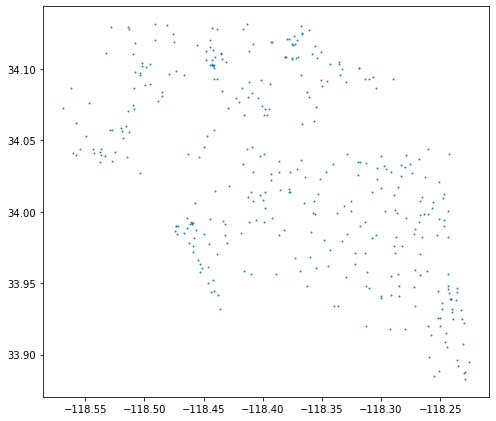

In [13]:
gdf.plot(figsize=(8, 8),
             markersize=0.8)

Hmm... This shows us a piece of the narrative, but it is important that we add more characteristics in order to further support the narrative of which region has more access to open parks.

In [14]:
gdf.access_type.value_counts()

Open Access          308
Restricted Access     21
No Public Access      19
Unknown Access        19
Name: access_type, dtype: int64

As you will note, a majority of the parks from this data are open access.

In [15]:
park_characteristics = gdf.access_type.value_counts().index.tolist()
park_characteristics

['Open Access', 'Restricted Access', 'No Public Access', 'Unknown Access']

In [16]:
gdf[gdf.access_type == 'Open Access'].head()

park_name  access_type     acres  \
0                                El Parque Nuestro  Open Access  0.530985   
1                             Mary M. Bethune Park  Open Access  5.314878   
2  Watts Towers of Simon Rodia State Historic Park  Open Access  0.108213   
3                    WAYS Reading and Fitness Park  Open Access  0.387581   
4               Metro Blue Line Open Space/Parkway  Open Access  3.646698   

                                         agency_name            agency_type  \
0                             Los Angeles, County of          County Agency   
1                             Los Angeles, County of          County Agency   
2      California Department of Parks and Recreation           State Agency   
3                                       Heal the Bay     Non Profit - Other   
4  Los Angeles County Metropolitan Transportation...  Transportation Agency   

             park_type               address         city    zip is_county  \
0           Local Park        1675 Gage Ave.  Los Angeles  90001       Yes   
1           Local Park      1244 E. 61st St.  Los Angeles  90001       Yes   
2  Regional Open Space       1727 E 107th St  Los Angeles  90002        No   
3  Regional Open Space  5115 Wilshire Blvd e  Los Angeles  90002        No   
4        Natural Areas       7225 Graham Ave  Los Angeles  90002        No   

                      geometry  
0  POINT (-118.24371 33.98236)  
1  POINT (-118.25304 33.98362)  
2  POINT (-118.24111 33.93873)  
3  POINT (-118.26086 33.95879)  
4  POINT (-118.24315 33.94818)

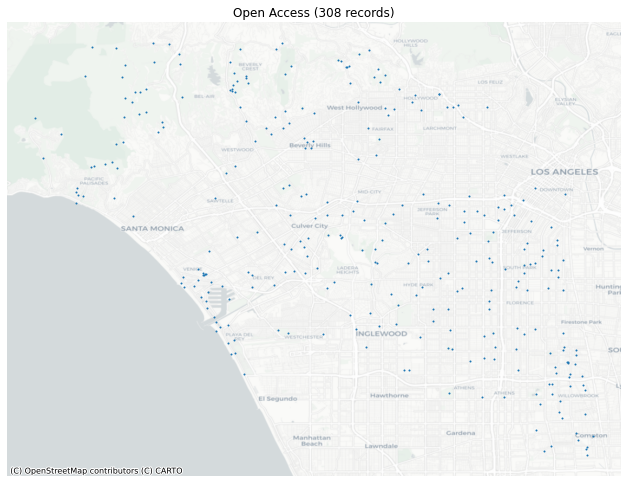

In [17]:
access_type = 'Open Access'

ax = gdf[gdf.access_type == access_type].plot(figsize=(11,11), markersize=1)

ax.set_title(access_type + ' (' + str(gdf[gdf.access_type == access_type].shape[0]) + ' records)')

ax.axis('off')

ctx.add_basemap(ax,
                crs='epsg:4326',
                source=ctx.providers.CartoDB.Positron)

This map shows all of the open access parks, which totals to 308 records. Still, the narrative is not shown as much by identifying the regions we are looking at with parks: West LA and South LA. We will use Seaborn plot maps in order to further identify our data.

## Trying out Seaborn Plots

In [18]:
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y

In order to use seaborn plots, I first must create separate columns for lat and lon.

In [19]:
gdf.head()

park_name  access_type     acres  \
0                                El Parque Nuestro  Open Access  0.530985   
1                             Mary M. Bethune Park  Open Access  5.314878   
2  Watts Towers of Simon Rodia State Historic Park  Open Access  0.108213   
3                    WAYS Reading and Fitness Park  Open Access  0.387581   
4               Metro Blue Line Open Space/Parkway  Open Access  3.646698   

                                         agency_name            agency_type  \
0                             Los Angeles, County of          County Agency   
1                             Los Angeles, County of          County Agency   
2      California Department of Parks and Recreation           State Agency   
3                                       Heal the Bay     Non Profit - Other   
4  Los Angeles County Metropolitan Transportation...  Transportation Agency   

             park_type               address         city    zip is_county  \
0           Local Park        1675 Gage Ave.  Los Angeles  90001       Yes   
1           Local Park      1244 E. 61st St.  Los Angeles  90001       Yes   
2  Regional Open Space       1727 E 107th St  Los Angeles  90002        No   
3  Regional Open Space  5115 Wilshire Blvd e  Los Angeles  90002        No   
4        Natural Areas       7225 Graham Ave  Los Angeles  90002        No   

                      geometry           x          y  
0  POINT (-118.24371 33.98236) -118.243713  33.982364  
1  POINT (-118.25304 33.98362) -118.253036  33.983620  
2  POINT (-118.24111 33.93873) -118.241115  33.938734  
3  POINT (-118.26086 33.95879) -118.260862  33.958788  
4  POINT (-118.24315 33.94818) -118.243146  33.948178

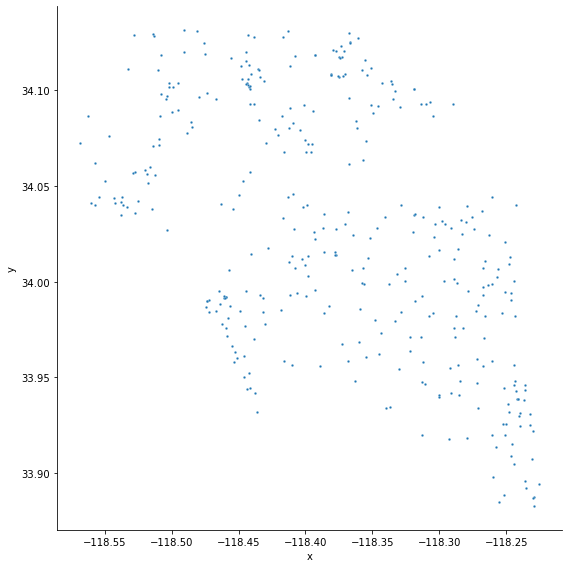

In [20]:
sns.relplot(data=gdf,
            x='x', 
            y='y',
            s=6, # size of point
            height=8 # size of plot
           )

This is very similar to the previous plotted maps we have. Let's add more detail!

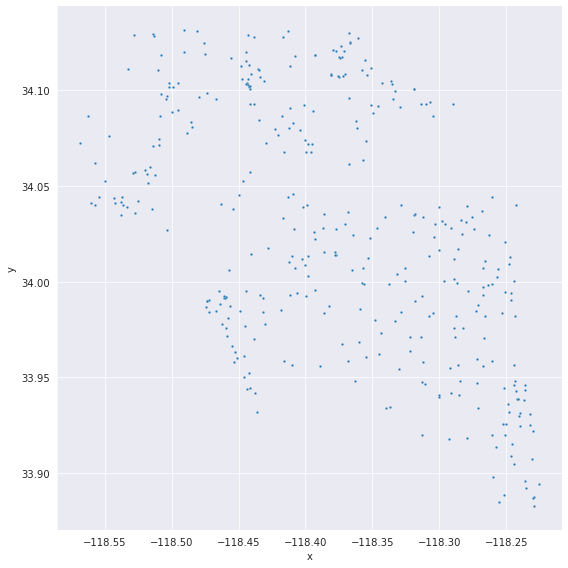

In [21]:
# seaborn comes with themes to make them prettier
sns.set_style('darkgrid')

# scatterplot 
sns.relplot(data=gdf,
            x='x', 
            y='y',
            s=6,
            height=8)

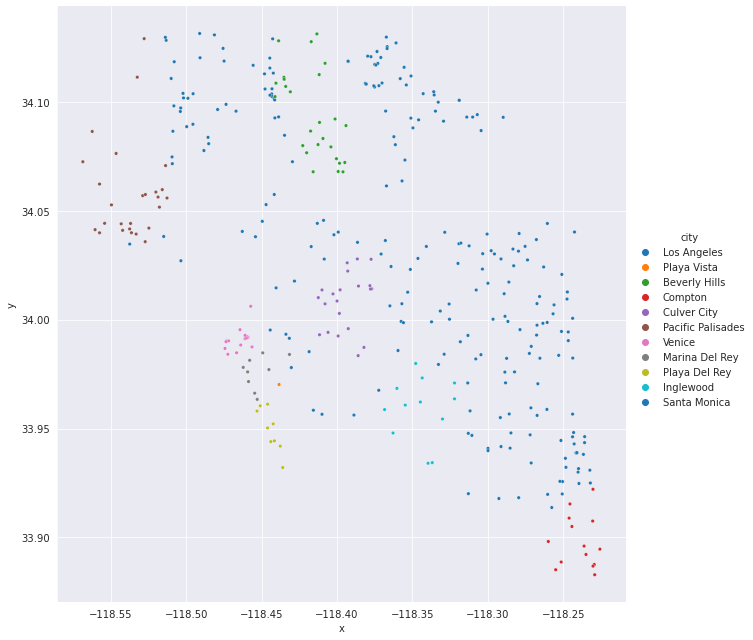

In [22]:
# scatterplot colored by area
sns.relplot(data=gdf,
            x='x', 
            y='y',
            hue='city',
            palette='tab10',
            s=12,
            height=9)

Now we can see the cities and the color coded parks. Los Angeles is split with West LA and South LA, Playa Vista, Beverly Hills, Culver City, Pacific Palisades, Venice, Marina Del Rey, Playa Del Rey, and Santa Monica are West LA. South LA is made up of Compton, Inglewood, and some points in Culver City.

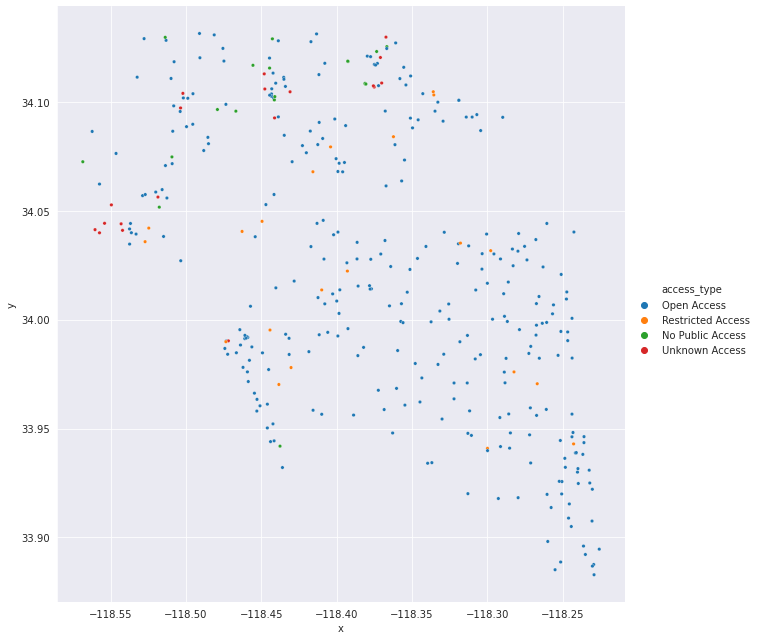

In [23]:
sns.relplot(data=gdf,
            x='x', 
            y='y',
            hue='access_type',
            palette='tab10',
            s=12,
            height=9)

This map shows the type of access, but as you can visualize, most are open access in both regions. It is interesting to see there is restricted access in South LA, and no public access in West LA. People must have private parks connected to their huge single-family homes.

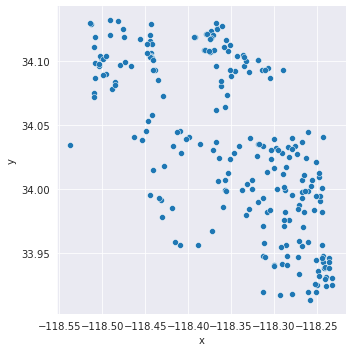

In [24]:
sns.relplot(data=gdf[gdf['city']=='Los Angeles'],
            x='x', 
            y='y')

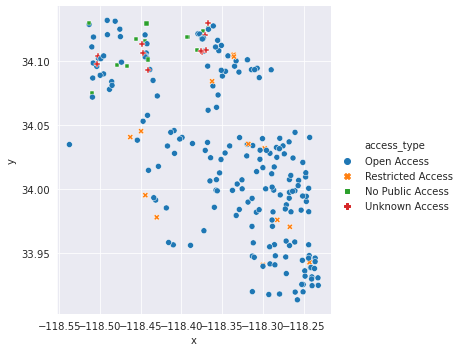

In [25]:
sns.relplot(data=gdf[gdf['city']=='Los Angeles'],
            x='x', 
            y='y',
            hue='access_type',
           style='access_type')

It is important to visualize the access type by city. here shows Los Angeles and its different access types.

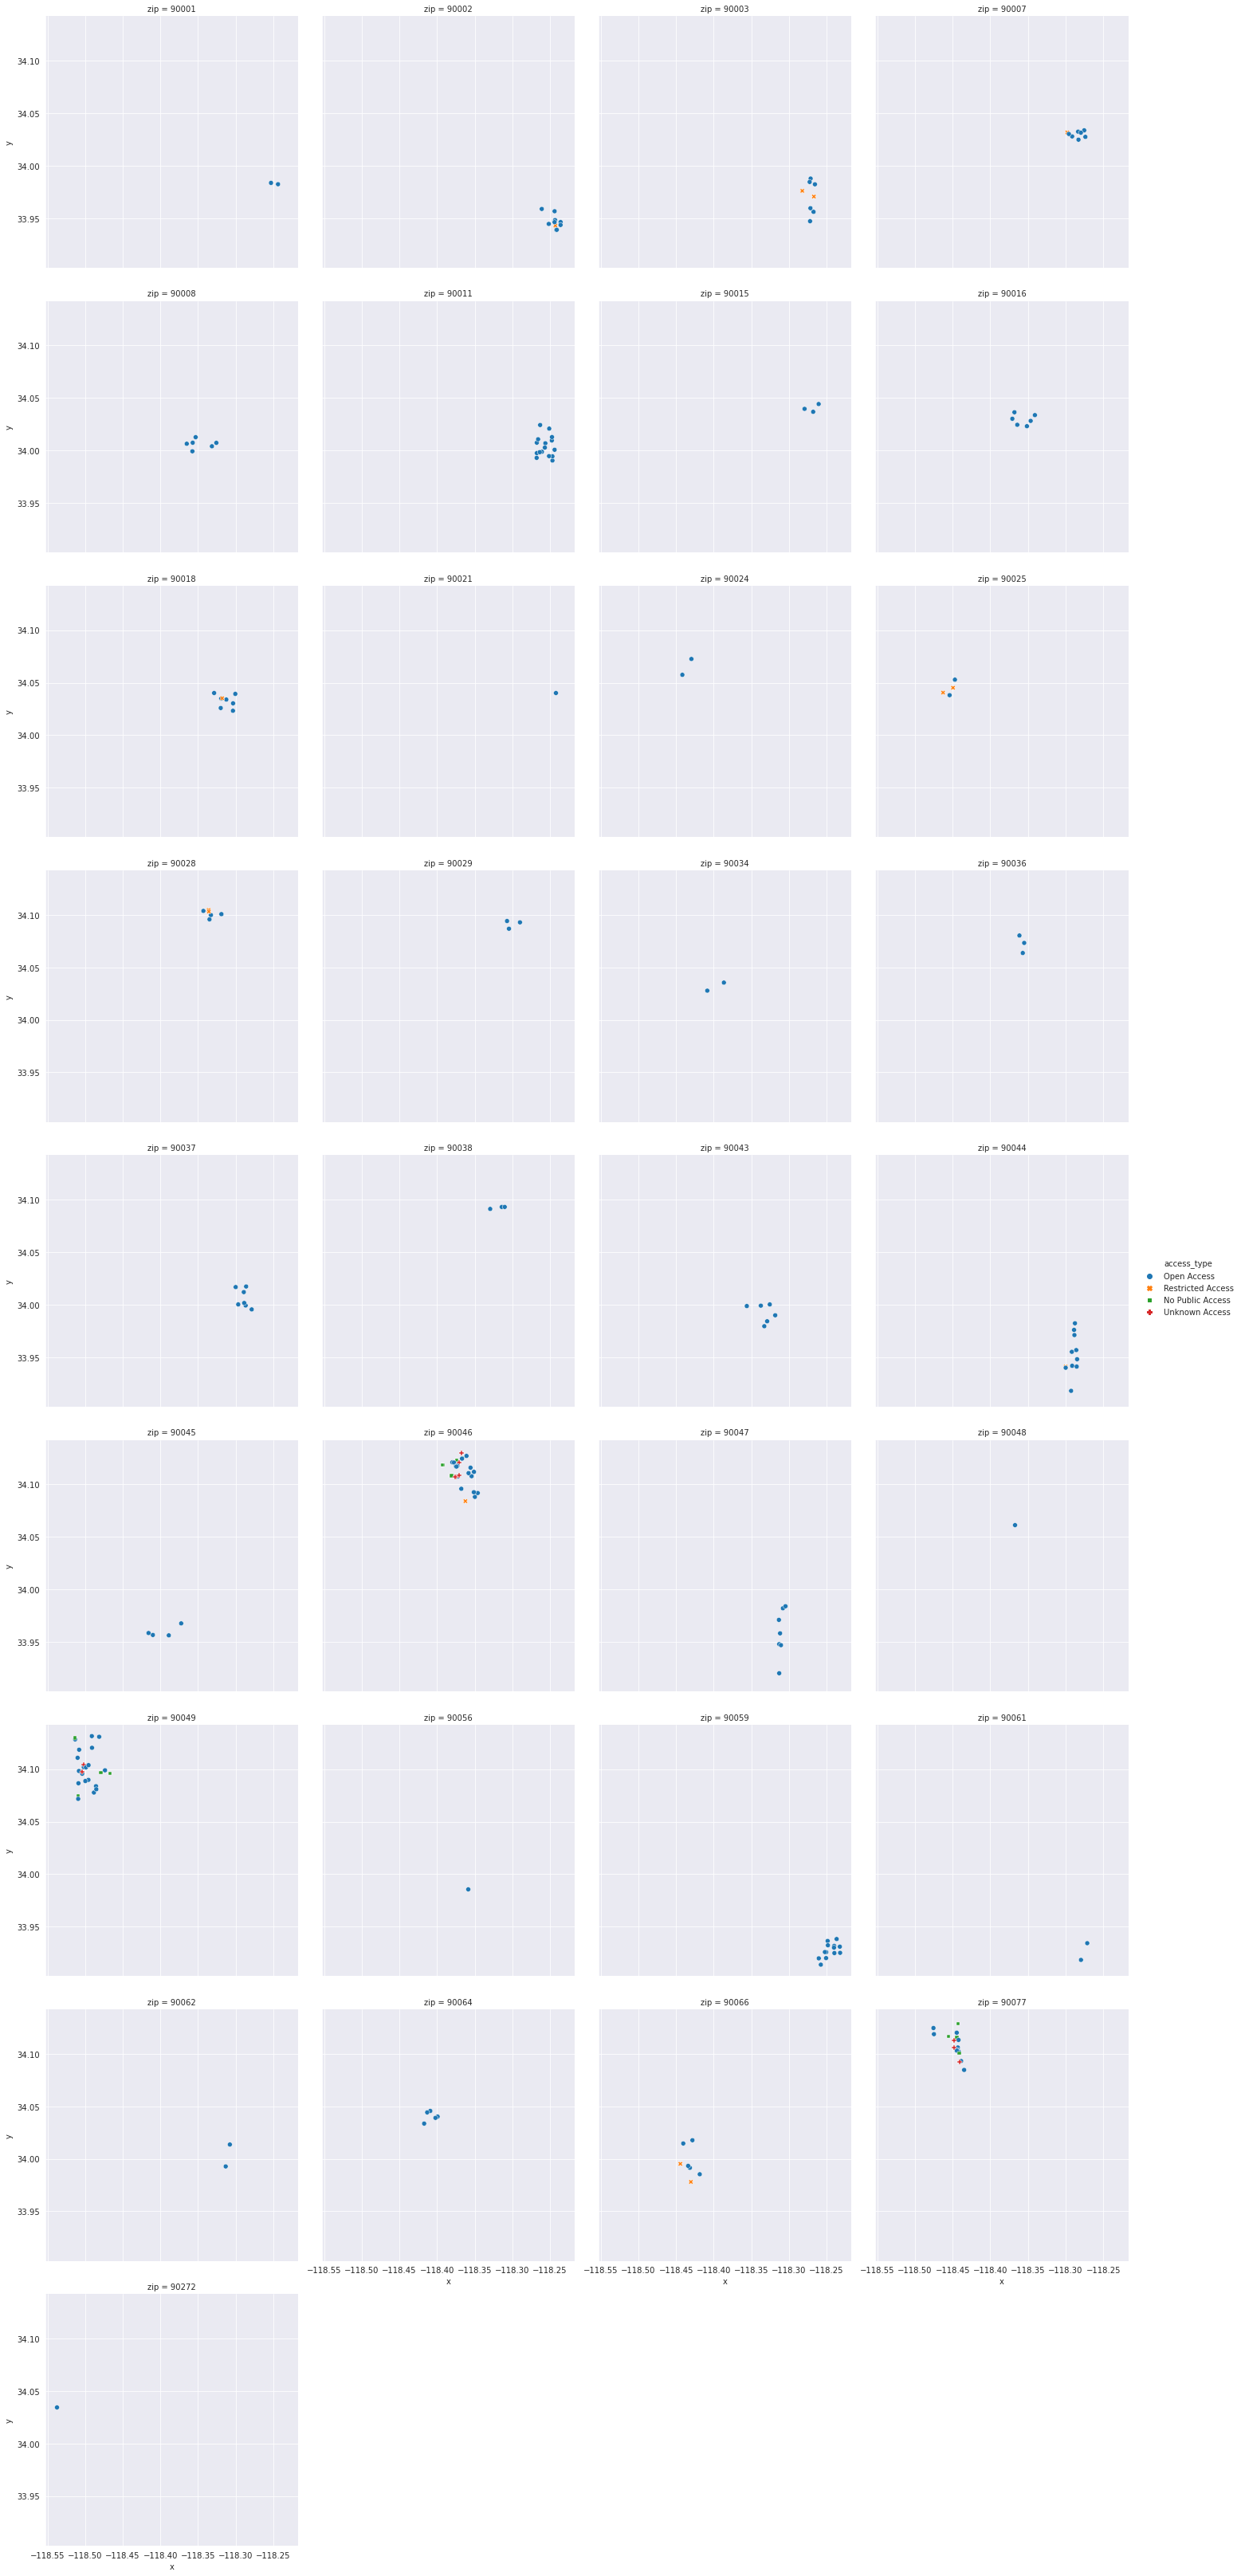

In [26]:
sns.relplot(data=gdf[gdf['city']=='Los Angeles'],
            x='x', 
            y='y',
            hue='access_type',
           style='access_type',
           col='zip',
            col_wrap=4)

These maps are very important because they show the type of park access per respective zip code in the entire dataset.

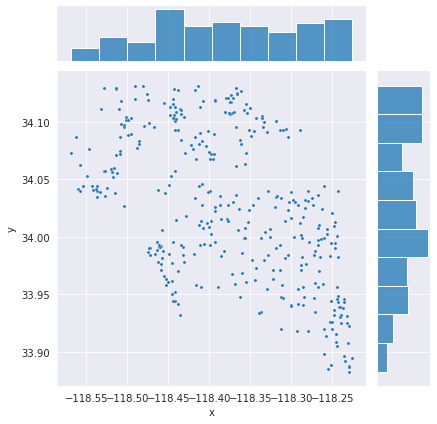

In [27]:
g = sns.jointplot(data = gdf,
                  x='x', 
                  y='y',
                  s=10)

This joint plot shows a scatter plot along with a plotted map.

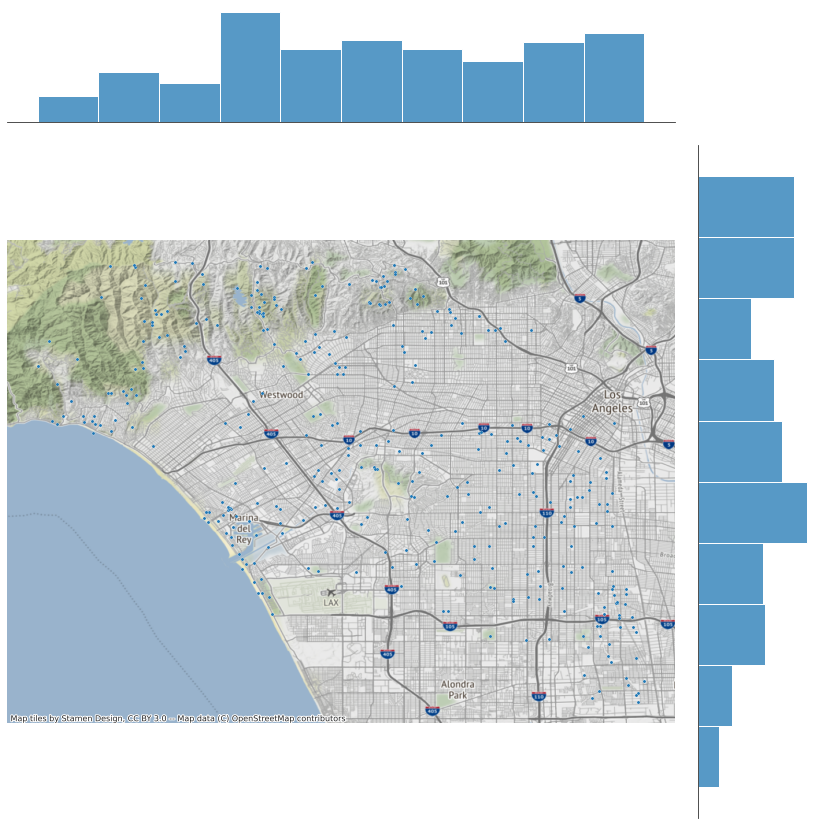

In [28]:
sns.set_style('white')
g = sns.jointplot(data = gdf,
                  x='x', 
                  y='y',
                  s=10,
                  height=12
                 )

g.ax_joint.set_axis_off()


ctx.add_basemap(g.ax_joint,
                crs='epsg:4326')

Adding a basemap on this seaborn joint plot allows for us to visualize the plots by the respective cities.

(-118.58569412537713, -118.20856297462286, 33.8704180775, 34.1439091525)

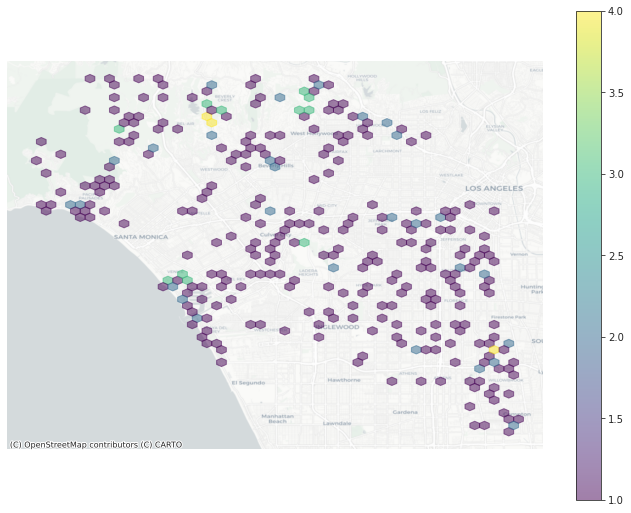

In [29]:
# Set up figure and axis
f, ax = plt.subplots(figsize=(12, 9))

# Generate and add hexbin with 50 hexagons in each 
# dimension, half transparency, ommitting grids with no crime,
# and using the viridis colormap
hb = ax.hexbin(
    x = gdf['x'], 
    y = gdf['y'],
    gridsize=50, 
    linewidths=1,
    alpha=0.5, 
    mincnt=1, # don't show zero
    cmap='viridis'
)

# Add basemap
ctx.add_basemap(
    ax, 
    crs='epsg:4326',
    source=ctx.providers.CartoDB.Positron
)

# Add colorbar
plt.colorbar(hb)

# Remove axes
ax.axis('off')

Hex-binning shows the level of density on the map. Notice how there are the most clustered areas in the North as well as in the Southeast. Most of the green hexagons are in the West side.

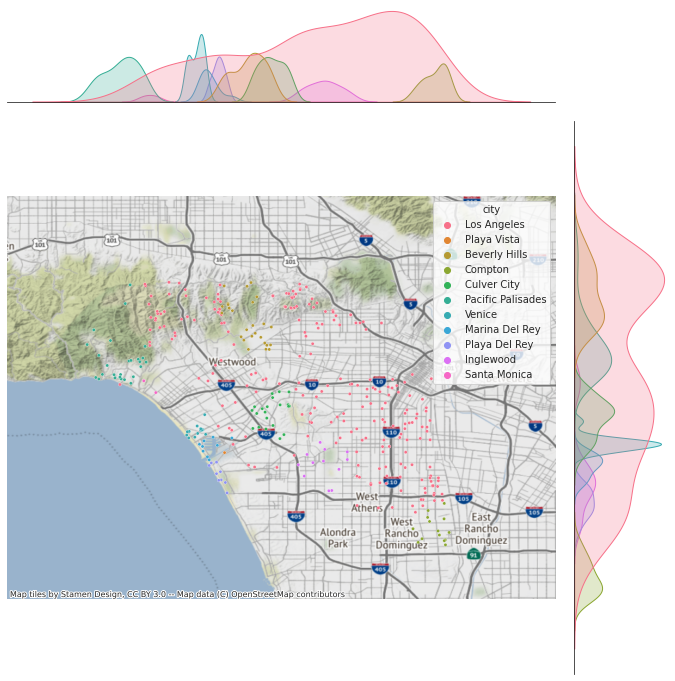

In [30]:
g = sns.jointplot(data = gdf,
                  x='x', 
                  y='y',
                  hue='city',
                  s=10,
                  height=10
                 )

g.ax_joint.set_axis_off()

ctx.add_basemap(g.ax_joint,
                crs='epsg:4326')

Los Angeles has the highest density but remember that both regions overlap in this city. The next most dense areas are Pacific Palisades, Beverly Hills, and Venice.

### Central Tendences: Mean and Median

The central tendencies show summaries of the descriptions of the point patterns.

In [31]:
mean_center = centrography.mean_center(gdf[['x','y']])
med_center = centrography.euclidean_median(gdf[['x','y']])

Now, let's visualize the mean and median on a scatterplot.

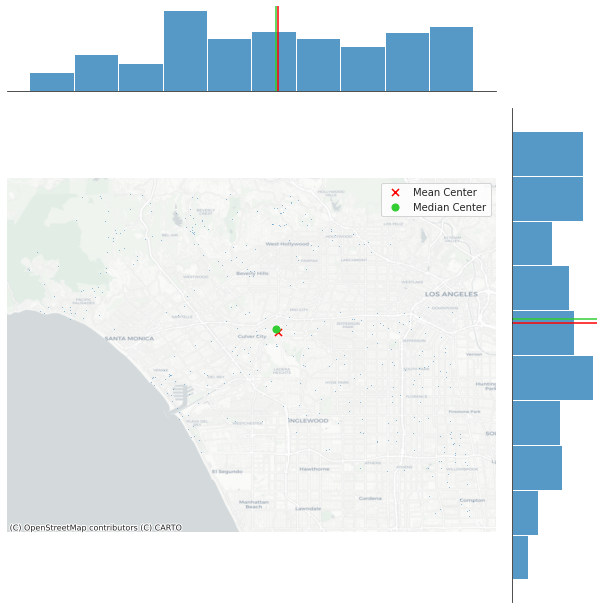

In [32]:
g = sns.jointplot(
    x='x', y='y', data=gdf, s=0.75, height=9
)


g.ax_joint.scatter(
    *mean_center, color='red', marker='x', s=50, label='Mean Center'
)
g.ax_marg_x.axvline(mean_center[0], color='red')
g.ax_marg_y.axhline(mean_center[1], color='red')

g.ax_joint.scatter(
    *med_center, color='limegreen', marker='o', s=50, label='Median Center'
)
g.ax_marg_x.axvline(med_center[0], color='limegreen')
g.ax_marg_y.axhline(med_center[1], color='limegreen')

g.ax_joint.legend()

ctx.add_basemap(
    g.ax_joint, 
    crs='epsg:4326',
    source=ctx.providers.CartoDB.Positron
)

g.ax_joint.set_axis_off()

plt.show()

Wow, it is interesting to note that the mean and median are very close and almost right on top of one another! This indicates a some symmetrical distribution within the data set.

### Central Tendences: Dispersion and Orientation

The directional distribution of the points can show another layer of how the data is spread over the region we are analyzing. This can be visualized using a standard deviational ellipse, that is rotated based on the orientation of the data.

In [33]:
major, minor, rotation = centrography.ellipse(gdf[['x','y']])

In [34]:
mean_center

array([-118.37630296,   34.02518281])

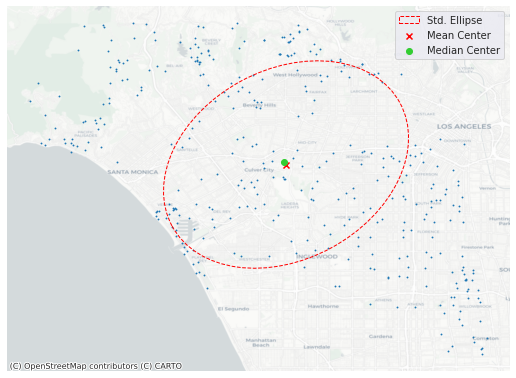

In [35]:
sns.set_style('dark')
f, ax = plt.subplots(1, figsize=(9, 9))
ax.scatter(gdf['x'], gdf['y'], s=0.75)
ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')
ellipse = Ellipse(xy=mean_center,
                  width=major*2,
                  height=minor*2, 
                  angle = numpy.rad2deg(rotation),
                  facecolor='none', 
                  edgecolor='red', 
                  linestyle='--',
                  label='Std. Ellipse')
ax.add_patch(ellipse)
ax.legend()
ax.axis('off')
ctx.add_basemap(ax,
                crs='epsg:4326',
                source=ctx.providers.CartoDB.Positron)
plt.show()

I got long error messages that I could not figure out when I tried to create a function to plot for each city and each access type, so I indivdually plotted for the ones that worked with open access. This is still important for the data as we can visualize where the parks are for each city.

In [114]:
def access_ellipse(area, access):
    
    access_filtered = gdf[(gdf.access_type == access) & (gdf.city == area)]

    mean_center = centrography.mean_center(access_filtered[['x','y']])
    med_center = centrography.euclidean_median(access_filtered[['x','y']])

    major, minor, rotation = centrography.ellipse(access_filtered[['x','y']])

    f, ax = plt.subplots(1, figsize=(9, 9))

    ax.scatter(access_filtered['x'], access_filtered['y'], s=3)

    ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
    ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

    ellipse = Ellipse(xy=mean_center,
                      width=major*2,
                      height=minor*2, 
                      angle = numpy.rad2deg(rotation), # Angles for this are in degrees, not radians
                      facecolor='none', 
                      edgecolor='red', linestyle='--',
                      label='Std. Ellipse')

    ax.add_patch(ellipse)

    ax.legend()

    ax.axis('on')

    ax.set_title(area + ': '+ access + '(for parks)')

    ctx.add_basemap(ax,
                    crs='epsg:4326',
                    source=ctx.providers.CartoDB.Positron)
    plt.show()

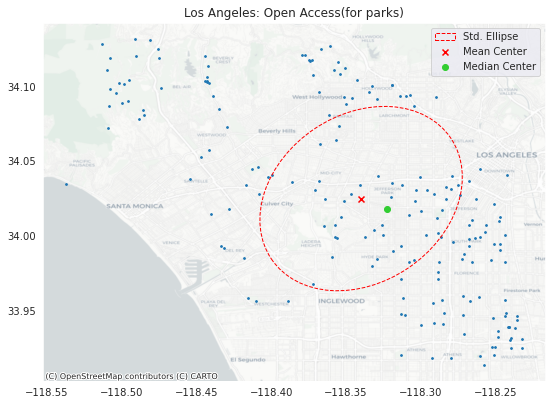

In [115]:
access_ellipse(area='Los Angeles',access='Open Access')

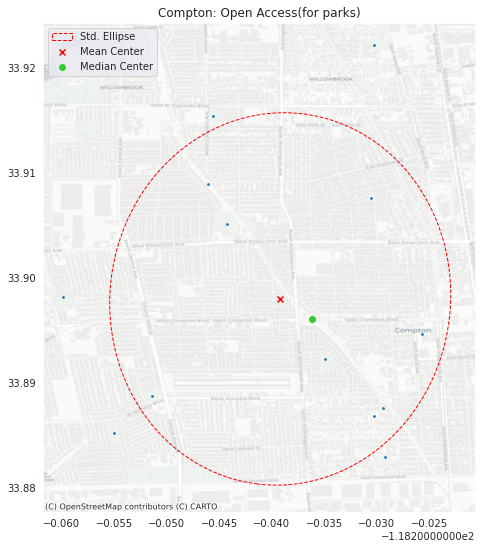

In [129]:
access_ellipse(area='Compton',access='Open Access')

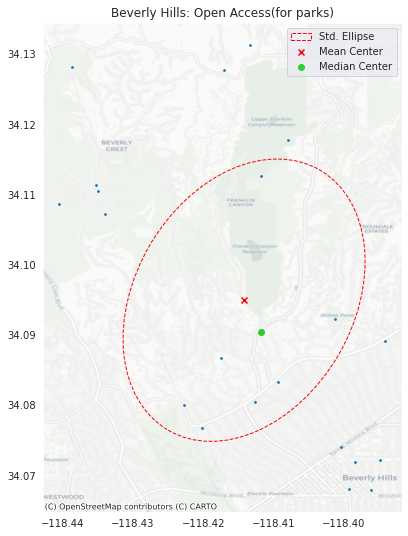

In [130]:
access_ellipse(area='Beverly Hills',access='Open Access')

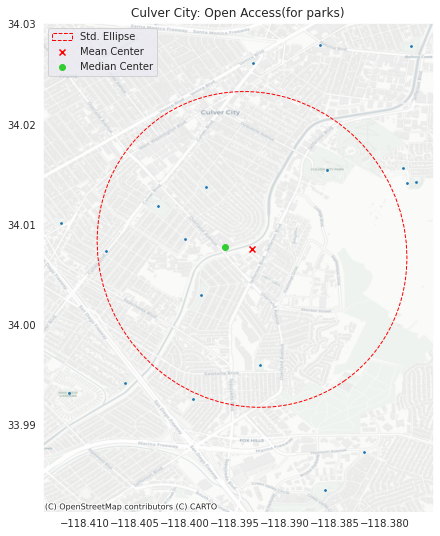

In [131]:
access_ellipse(area='Culver City',access='Open Access')

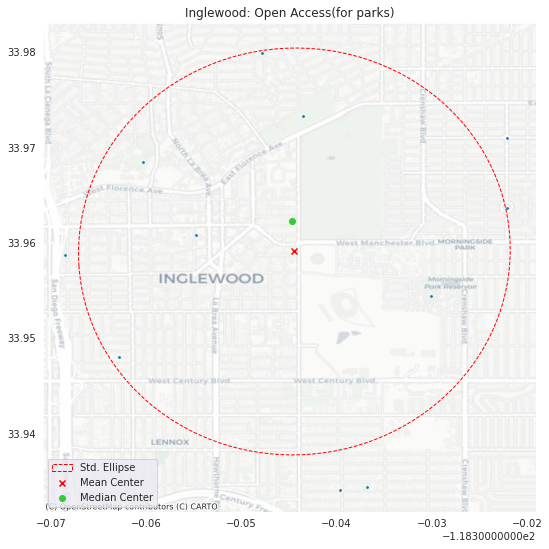

In [133]:
access_ellipse(area='Inglewood',access='Open Access')

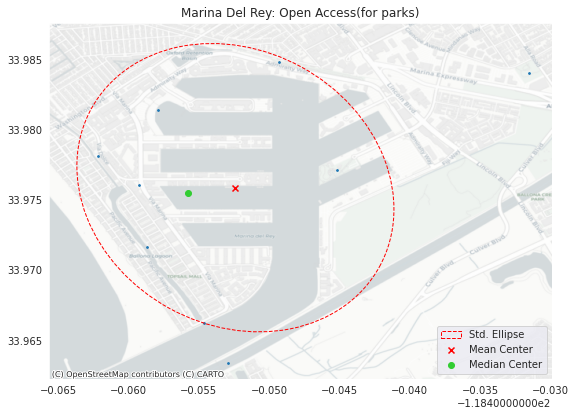

In [134]:
access_ellipse(area='Marina Del Rey',access='Open Access')

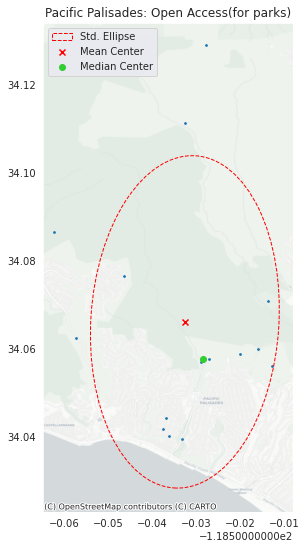

In [135]:
access_ellipse(area='Pacific Palisades',access='Open Access')

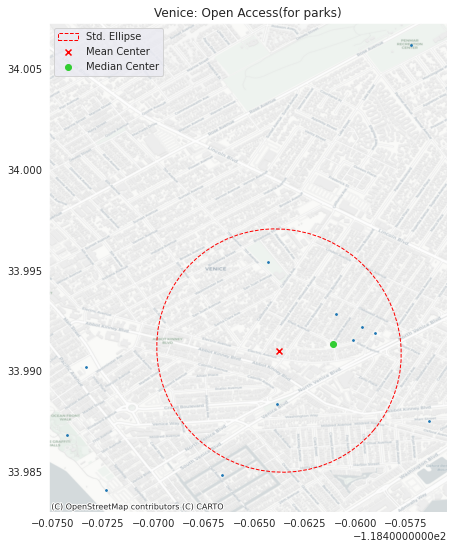

In [136]:
access_ellipse(area='Venice',access='Open Access')

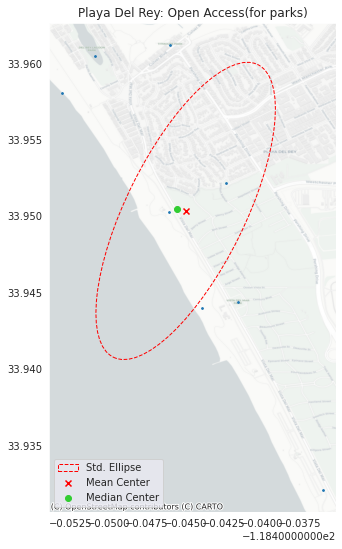

In [140]:
access_ellipse(area='Playa Del Rey',access='Open Access')

Samantha Guerrero focused on the parks and open access data set.